# Classification by standard ML approach
In the following, we will run some experiments using some of the standard ML approaches, such as Random Forest, MLP, SVMs. These naïve methods will exploit the list of ingredients, rather than the structure of the entire recipe itself. This reasoning comes up naturally when considering such standards ML practices, since they do not keep in consideration the semantic structure of the sentences and do not share any weight in the network

### Imports

In [2]:
from tqdm.auto import tqdm
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

/Users/nicolapitzalis/anaconda3/envs/hlt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading

In [5]:
PATH_DATA = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/ingredients_list_10k_balanced.csv'
PATH_LABELS = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/labels_10k_balanced.csv'
PATH_VOCABULARY = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/ingredients_v_10k_balanced.csv'
PATH_RECIPES = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/recipes_df_10k_balanced.csv'

data = pd.read_csv(PATH_DATA, low_memory=False)
vocabulary = pd.read_csv(PATH_VOCABULARY)
labels = pd.read_csv(PATH_LABELS)

In [4]:
# recipes = pd.read_csv(PATH_RECIPES)
# labels = recipes['Vegetarian&Desserts']
# labels.to_csv(PATH_LABELS, index=False)

### Preprocessing
We need to create the one_hot_encoded version of the ingredients, both for the ingredient's vocabulary and for the matrix of recipes.

In [6]:
vocabulary = vocabulary.fillna('Missing')
ohe_vocabulary = pd.get_dummies(vocabulary, prefix='category').astype(int)

In [7]:
ohe_matrix = []

# Loop over each recipe in the data
for index, recipe in data.iterrows():
    ohe_recipe = np.zeros(len(ohe_vocabulary.columns))
    
    for ingredient in recipe:
        if pd.isnull(ingredient):
            continue
        
        # Check if the ingredient is in the one-hot vocabulary
        if f'category_{ingredient}' in ohe_vocabulary.columns:
            # Find the index for the ingredient
            ingredient_index = ohe_vocabulary.columns.get_loc(f'category_{ingredient}')
            
            # Set the corresponding position in ohe_recipe to 1
            ohe_recipe[ingredient_index] = 1

    ohe_matrix.append(ohe_recipe)

ohe_matrix = np.array(ohe_matrix)

In [8]:
labels = labels['Vegetarian&Desserts'].to_numpy()

## Classification

In [9]:
X_train, X_test, y_train, y_test = train_test_split(ohe_matrix, labels, test_size=0.3, random_state=42, stratify=labels)

In [10]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5000, 1: 5000}


In [11]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3500, 1: 3500}


In [12]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1500, 1: 1500}


### Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]  
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

In [18]:
random_forest = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=42, max_depth=None, min_samples_split=5, min_samples_leaf=1, n_jobs=-1)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy: 0.7406666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.76      1500
           1       0.78      0.68      0.72      1500

    accuracy                           0.74      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.74      0.74      0.74      3000

Accuracy Score: 0.7406666666666667


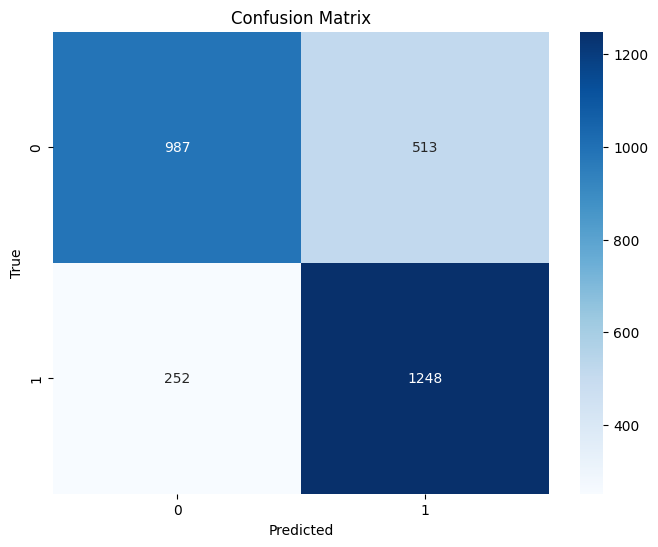

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
for i, tree in enumerate(random_forest.estimators_):
    tree_rules = export_text(tree, feature_names=list(ohe_vocabulary.columns))
    
    print(f"Rules for tree {i}:\n")
    print(tree_rules)
    print("\n")

### MLP

In [15]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001,
                    solver='adam', verbose=10, random_state=21, learning_rate_init=0.01)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Iteration 1, loss = 0.52897924
Iteration 2, loss = 0.15965208
Iteration 3, loss = 0.04160513
Iteration 4, loss = 0.02024740
Iteration 5, loss = 0.01513560
Iteration 6, loss = 0.01320810
Iteration 7, loss = 0.01178408
Iteration 8, loss = 0.01140146
Iteration 9, loss = 0.01097907
Iteration 10, loss = 0.01098597
Iteration 11, loss = 0.01062447
Iteration 12, loss = 0.01133084
Iteration 13, loss = 0.01021279
Iteration 14, loss = 0.01107893
Iteration 15, loss = 0.01019794
Iteration 16, loss = 0.01021554
Iteration 17, loss = 0.01031244
Iteration 18, loss = 0.01080318
Iteration 19, loss = 0.01066906
Iteration 20, loss = 0.01000404
Iteration 21, loss = 0.01049755
Iteration 22, loss = 0.00984054
Iteration 23, loss = 0.00988541
Iteration 24, loss = 0.01064129
Iteration 25, loss = 0.00994970
Iteration 26, loss = 0.00965174
Iteration 27, loss = 0.00939473
Iteration 28, loss = 0.01149718
Iteration 29, loss = 0.01112989
Iteration 30, loss = 0.01049127
Iteration 31, loss = 0.00979851
Iteration 32, los

Confusion Matrix:
[[1694  307]
 [ 400  599]]


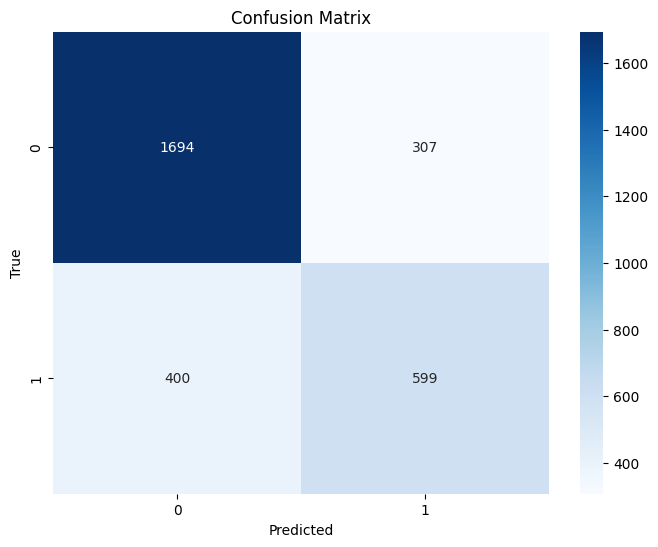

In [25]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVM

In [ ]:
param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))


In [16]:
svc = SVC(C=100, kernel='rbf', gamma=0.001)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72      1500
           1       0.71      0.83      0.77      1500

    accuracy                           0.74      3000
   macro avg       0.75      0.74      0.74      3000
weighted avg       0.75      0.74      0.74      3000



Confusion Matrix:
[[ 987  513]
 [ 252 1248]]


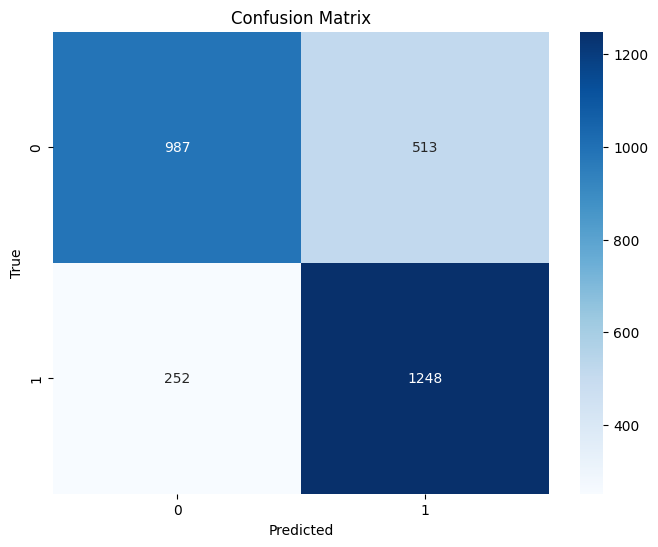

In [17]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()